# Liver Cirhosis Risk Prediction/Classification

## Data Preprocessing

In [331]:
import copy
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [332]:
#Load Dataset
cir_df = pd.read_csv("cirrhosis.csv")

In [333]:
#Check duplicate
len(pd.unique(cir_df["ID"])) == len(cir_df.index)

True

In [334]:
cir_df.isna().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

<Axes: >

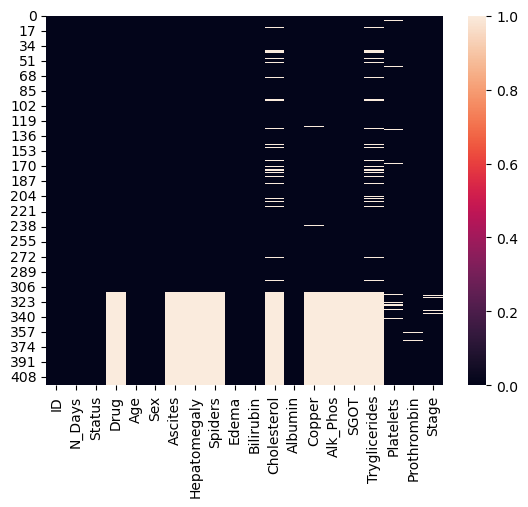

In [335]:
sns.heatmap(cir_df.isnull())

In [336]:
cir_df = cir_df.drop(columns = ["ID"])
#Drop rows with too much null value
cir_df = cir_df[cir_df["Drug"].isna() == False]
#Impute other null value with median
fill_values = {"Tryglicerides": np.nanmedian(cir_df["Tryglicerides"]), 
               "Platelets": np.nanmedian(cir_df["Platelets"]), 
               "Cholesterol": np.nanmedian(cir_df["Cholesterol"]), 
               "Copper": np.nanmedian(cir_df["Copper"])}
cir_df = cir_df.fillna(value = fill_values)
#Convert age into year
cir_df["Age"] = (cir_df["Age"]/365).astype('int')
#Replace binary values with 0,1
cir_df["Sex"] = np.where(cir_df["Sex"] == "M",1,0)
cir_df["Ascites"] = np.where(cir_df["Ascites"] == "Y",1,0)
cir_df["Hepatomegaly"] = np.where(cir_df["Hepatomegaly"] == "Y",1,0)
cir_df["Spiders"] = np.where(cir_df["Spiders"] == "Y",1,0)
cir_df["Drug"] = np.where(cir_df["Drug"] == "D-penicillamine",1,0)
#cir_df["Stage"] = "stage_" + cir_df["Stage"].astype(int).astype(str)

In [337]:
cir_df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,1,58,0,1,1,1,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,1,56,0,0,1,1,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,1,70,1,0,0,0,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,1,54,0,0,1,1,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,0,38,0,0,1,1,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


## EDA

In [338]:
cir_df.describe()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000
mean,2006.362179,0.506410,49.538462,0.115385,0.076923,0.512821,0.288462,3.256090,364.125000,3.520000,97.490385,1982.655769,122.556346,123.096154,261.871795,10.725641,3.032051
std,1123.280843,0.500762,10.590528,0.319999,0.266897,0.500639,0.453775,4.530315,221.923027,0.419892,85.360932,2140.388824,56.699525,62.122820,94.993533,1.004323,0.877880
min,41.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1191.000000,0.000000,41.750000,0.000000,0.000000,0.000000,0.000000,0.800000,255.750000,3.310000,41.750000,871.500000,80.600000,87.000000,200.000000,10.000000,2.000000
50%,1839.500000,1.000000,49.000000,0.000000,0.000000,1.000000,0.000000,1.350000,309.500000,3.550000,73.000000,1259.000000,114.700000,108.000000,257.000000,10.600000,3.000000
75%,2697.250000,1.000000,56.000000,0.000000,0.000000,1.000000,1.000000,3.425000,392.250000,3.800000,123.000000,1980.000000,151.900000,145.250000,322.000000,11.100000,4.000000
max,4556.000000,1.000000,78.000000,1.000000,1.000000,1.000000,1.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000,4.000000


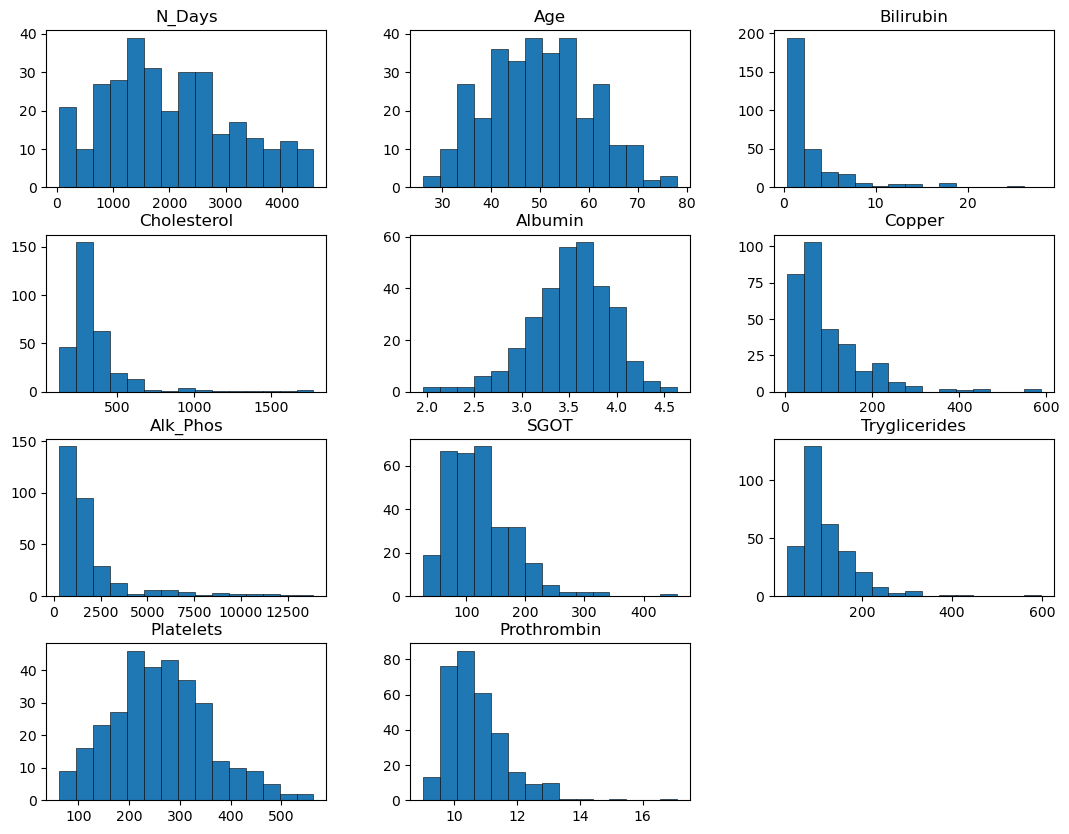

In [339]:
continous_df = cir_df.loc[:, ~cir_df.columns.isin(['Status', 'Stage', 'Edema','Drug','Sex','Ascites','Hepatomegaly','Spiders'])]
histogram = continous_df.hist(figsize=(13, 10), bins = 15 ,grid = False, edgecolor='black', linewidth = 0.4)

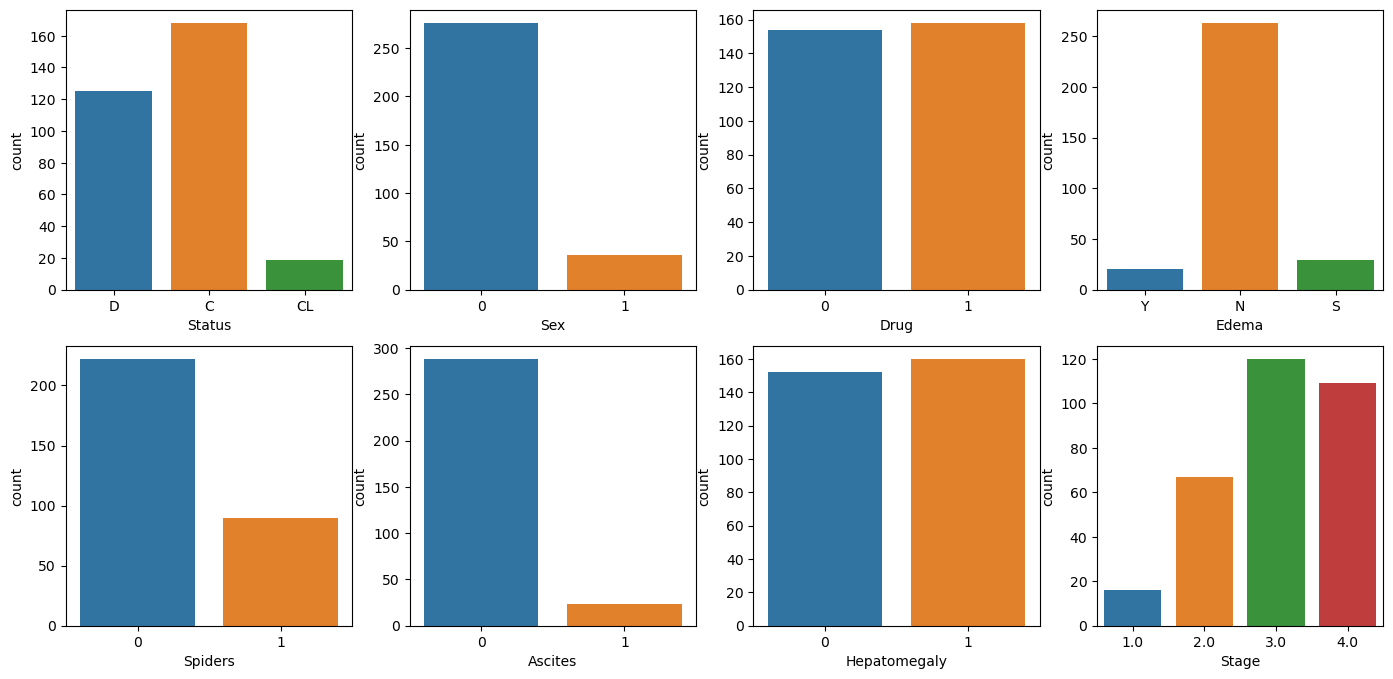

In [340]:
category_df = cir_df.loc[:, cir_df.columns.isin(['Status', 'Stage', 'Edema','Drug','Sex','Ascites','Hepatomegaly','Spiders'])]
fig, ax = plt.subplots(2, 4, figsize = (17,8))
axis = [['Status', 'Sex','Drug','Edema'],['Spiders','Ascites','Hepatomegaly','Stage']]
for i in range(2):
    for j in range(4):
        subplot = sns.countplot(ax = ax[i,j] ,x = axis[i][j], data = category_df)

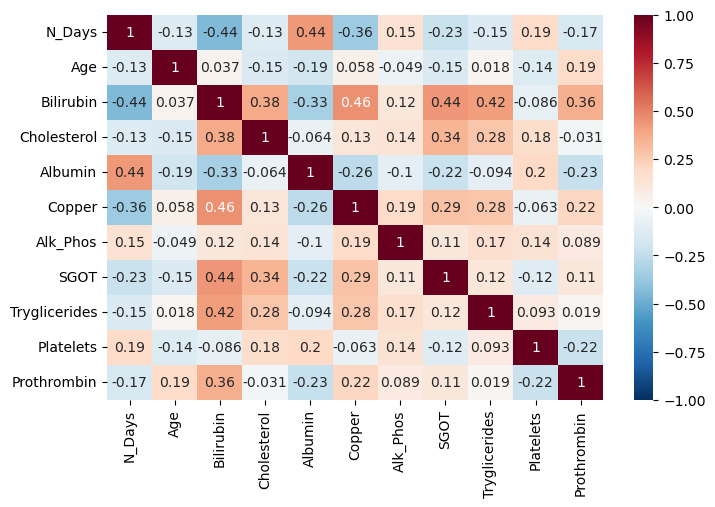

In [341]:
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(continous_df.corr(), cmap = 'RdBu_r', vmin=-1, vmax=1, annot=True)

In [342]:
cir_df = cir_df.drop(columns = ['Status','N_Days'])

In [343]:
cir_df

,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,58,0,1,1,1,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,1,56,0,0,1,1,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1,70,1,0,0,0,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1,54,0,0,1,1,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,0,38,0,0,1,1,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,1,61,0,0,1,0,N,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2.0
308,0,58,0,0,0,0,N,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2.0
309,1,62,0,0,0,0,N,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2.0
310,1,38,0,0,0,0,N,2.0,247.0,3.16,69.0,1050.0,117.00,88.0,335.0,10.5,2.0


## Model

### XGBoost
#### Mainsteps:
1. Fit model using xgboost
1. Feature selection ***

In [344]:
#One-hot encoding
target = cir_df["Stage"]
target = target - 1
features = cir_df.drop(columns = ["Stage"])
features["Edema"] = features["Edema"].astype('category')
features = pd.get_dummies(features)

In [345]:
features["Edema_Y"] = features["Edema_Y"].astype('int')
features["Edema_S"] = features["Edema_S"].astype('int')
features["Edema_N"] = features["Edema_N"].astype('int')

In [346]:
target = np.where(target == 3,1,0)

In [347]:
#60,20,20 train,val,test,split
from sklearn.model_selection import train_test_split
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(features, target, test_size=0.2, random_state=1)
X_xgb_train, X_xgb_val, y_xgb_train, y_xgb_val = train_test_split(X_xgb_train, y_xgb_train, test_size=0.25, random_state=1)

In [348]:
import xgboost as xgb
model = xgb.XGBClassifier(n_estimators=100, max_depth=10, eta=0.05)
model.fit(X_xgb_train, y_xgb_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [349]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_xgb_val, model.predict(X_xgb_val)))
rmse

0.41785544701867244

In [405]:
from sklearn.metrics import accuracy_score
accuracy_score(model.predict(X_xgb_val),y_xgb_val)

0.8253968253968254

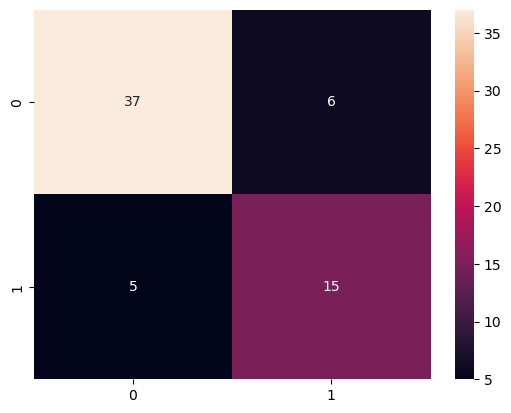

In [351]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(model.predict(X_xgb_val),y_xgb_val)
sns.heatmap(cm, annot=True)
plt.show()

In [352]:
print(classification_report(y_xgb_val,model.predict(X_xgb_val)))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        42
           1       0.75      0.71      0.73        21

    accuracy                           0.83        63
   macro avg       0.81      0.80      0.80        63
weighted avg       0.82      0.83      0.82        63



In [409]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(model.predict(X_xgb_val),y_xgb_val)

0.6024096385542168

In [354]:
#dmatrix = xgb.DMatrix(data=X_xgb_train, label=y_xgb_train)
#params={'objective':'multi:softmax'}
#cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'rmse'}, as_pandas=True, seed=20)
#print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

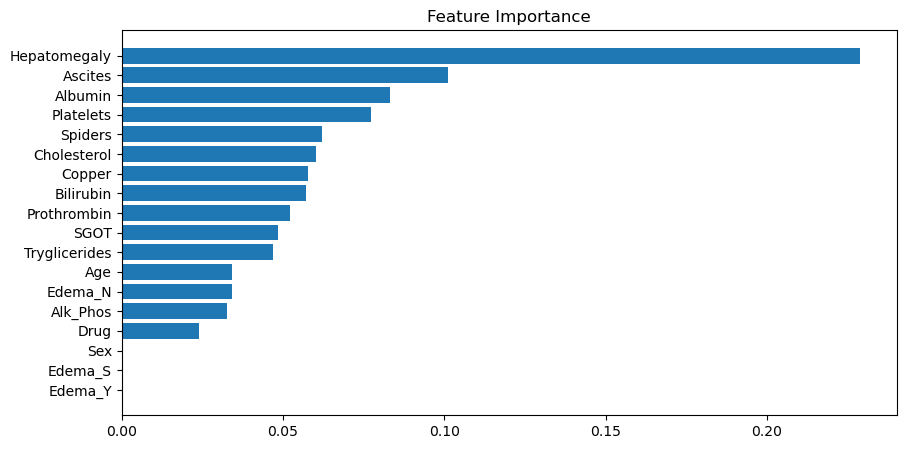

In [408]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_xgb_val.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [427]:
model2 = xgb.XGBClassifier(n_estimators=100, max_depth=10, eta=0.05)
model2.fit(X_xgb_train[["Hepatomegaly","Ascites"]], y_xgb_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [428]:
rmse = np.sqrt(mean_squared_error(y_xgb_val, model2.predict(X_xgb_val[["Hepatomegaly","Ascites"]])))
rmse

0.5039526306789697

In [429]:
accuracy_score(model2.predict(X_xgb_val[["Hepatomegaly","Ascites"]]),y_xgb_val)

0.746031746031746

### Proportional Odds Model
#### Main steps:
1. Prepare duplicate dataset
1. Convert outcome (Stage) into categorical value
2. fit proportional odds model for remaining data
3. Feature selection (How?) ***

In [370]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from pandas.api.types import CategoricalDtype

X = features.drop(columns=['Edema_N'])
y = copy.deepcopy(cir_df["Stage"].replace([1.,2.,3.,4.],["stage_1", "stage_2", "stage_3","stage_4"]))
stage_type = CategoricalDtype(categories=["stage_1", "stage_2", "stage_3","stage_4"], ordered=True)
y = y.astype(stage_type)


X_polr_train, X_polr_test, y_polr_train, y_polr_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_polr_train, X_polr_val, y_polr_train, y_polr_val = train_test_split(X_polr_train, y_polr_train, test_size=0.25, random_state=1)



In [371]:
y

0      stage_4
1      stage_3
2      stage_4
3      stage_4
4      stage_3
        ...   
307    stage_2
308    stage_2
309    stage_2
310    stage_2
311    stage_2
Name: Stage, Length: 312, dtype: category
Categories (4, object): ['stage_1' < 'stage_2' < 'stage_3' < 'stage_4']

In [434]:
model_ordered_reg = OrderedModel(y_polr_train,
                                 X_polr_train,
                                 distr='logit')

res_log = model_ordered_reg.fit(method='newton', disp=False)
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  Stage   Log-Likelihood:                -191.53
Model:                   OrderedModel   AIC:                             423.1
Method:            Maximum Likelihood   BIC:                             487.6
Date:                Sat, 18 Mar 2023                                         
Time:                        02:31:01                                         
No. Observations:                 186                                         
Df Residuals:                     166                                         
Df Model:                          20                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Drug               -0.0301      0.294     -0.102      0.919      -0.606       0.546
Age                 0.0262      0.016      1.658      0.097      -0.005       0.057
Sex                -0.9460      0.604     -1.566      0.117      -2.130       0.238
Ascites             1.6469      1.016      1.621      0.105      -0.344       3.638
Hepatomegaly        1.7374      0.342      5.085      0.000       1.068       2.407
Spiders             0.2109      0.367      0.575      0.565      -0.508       0.929
Bilirubin          -0.0685      0.048     -1.413      0.158      -0.164       0.027
Cholesterol      8.552e-05      0.001      0.102      0.919      -0.002       0.002
Albumin            -0.7079      0.445     -1.590      0.112      -1.580       0.165
Copper              0.0047      0.003      1.791      0.073      -0.000       0.010
Alk_Phos        -4.155e-05   6.54e-05     -0.636      0.525      -0.000    8.66e-05
SGOT                0.0037      0.003      1.209      0.226      -0.002       0.010
Tryglicerides       0.0004      0.003      0.147      0.883      -0.005       0.006
Platelets          -0.0008      0.002     -0.481      0.631      -0.004       0.003
Prothrombin         0.3241      0.195      1.658      0.097      -0.059       0.707
Edema_S            -0.0099      0.557     -0.018      0.986      -1.101       1.081
Edema_Y            -0.6873      0.976     -0.705      0.481      -2.600       1.225
stage_1/stage_2     0.0822      2.981      0.028      0.978      -5.760       5.924
stage_2/stage_3     0.7497      0.154      4.870      0.000       0.448       1.051
stage_3/stage_4     0.8180      0.107      7.635      0.000       0.608       1.028
===================================================================================
"""

In [435]:
def polr_predict(df,model):
    prob = model.predict(df)
    max_prob = prob.idxmax(axis = 1)
    max_prob[max_prob == 0] = 'stage_1'
    max_prob[max_prob == 1] = 'stage_2'
    max_prob[max_prob == 2] = 'stage_3'
    max_prob[max_prob == 3] = 'stage_4'
    
    return max_prob

In [436]:
accuracy_score(polr_predict(X_polr_val,res_log),y_polr_val)

0.5238095238095238

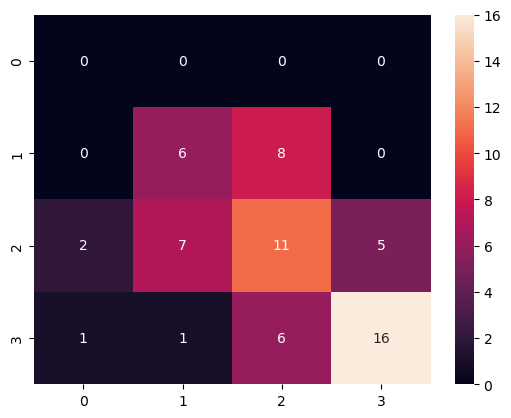

In [438]:
cm2 = confusion_matrix(polr_predict(X_polr_val,res_log),y_polr_val)
sns.heatmap(cm2, annot=True)
plt.show()

### Multilayer Perceptron Neural Network
#### Main steps:
1. Build function finding optimal number of layer and neurons (tensorflow).
2. Feature selection ***

In [ ]:
#Need one-hot encoding for Endema and stage

$N_h = \frac{N_s}{\alpha  (N_i+N_o)}$

## Performance Evaluation